# **SpaceX  Falcon 9 first stage Landing Prediction**


# Lab 1: Collecting the data


In this capstone, I predict if the Falcon 9 first stage will land successfully. SpaceX advertises Falcon 9 rocket launches on its website with a cost of 62 million dollars; other providers cost upward of 165 million dollars each, much of the savings is because SpaceX can reuse the first stage. Therefore if we can determine if the first stage will land, we can determine the cost of a launch. This information can be used if an alternate company wants to bid against SpaceX for a rocket launch. In this lab, I will collect and make sure the data is in the correct format from an API. The following is an example of a successful launch.


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/lab_v2/images/landing_1.gif)


Several examples of an unsuccessful landing are shown here:


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/lab_v2/images/crash.gif)


Most unsuccessful landings are planned. Space X performs a controlled landing in the oceans.


## Objectives


In this lab, I will make a get request to the SpaceX API. I will also do some basic data wrangling and formating.

- Request to the SpaceX API
- Clean the requested data


----


## Import Libraries and Define Auxiliary Functions


We will import the following libraries into the lab


In [1]:
import requests
import pandas as pd
import numpy as np
import datetime

# Setting this option will print all collumns of a dataframe
pd.set_option('display.max_columns', None)
# Setting this option will print all of the data in a feature
pd.set_option('display.max_colwidth', None)

Below defined are a series of helper functions that will help use the API to extract information using identification numbers in the launch data.

From the <code>rocket</code> column we would like to learn the booster name.


In [2]:
# Takes the dataset and uses the rocket column to call the API and append the data to the list
def getBoosterVersion(data):
    for x in data['rocket']:
       if x:
        response = requests.get("https://api.spacexdata.com/v4/rockets/"+str(x)).json()
        BoosterVersion.append(response['name'])

From the <code>launchpad</code> we would like to know the name of the launch site being used, the logitude, and the latitude.


In [3]:
# Takes the dataset and uses the launchpad column to call the API and append the data to the list
def getLaunchSite(data):
    for x in data['launchpad']:
       if x:
         response = requests.get("https://api.spacexdata.com/v4/launchpads/"+str(x)).json()
         Longitude.append(response['longitude'])
         Latitude.append(response['latitude'])
         LaunchSite.append(response['name'])

From the <code>payload</code> we would like to learn the mass of the payload and the orbit that it is going to.


In [4]:
# Takes the dataset and uses the payloads column to call the API and append the data to the lists
def getPayloadData(data):
    for load in data['payloads']:
       if load:
        response = requests.get("https://api.spacexdata.com/v4/payloads/"+load).json()
        PayloadMass.append(response['mass_kg'])
        Orbit.append(response['orbit'])

From <code>cores</code> we would like to learn the outcome of the landing, the type of the landing, number of flights with that core, whether gridfins were used, wheter the core is reused, wheter legs were used, the landing pad used, the block of the core which is a number used to seperate version of cores, the number of times this specific core has been reused, and the serial of the core.


In [5]:
# Takes the dataset and uses the cores column to call the API and append the data to the lists
def getCoreData(data):
    for core in data['cores']:
            if core['core'] != None:
                response = requests.get("https://api.spacexdata.com/v4/cores/"+core['core']).json()
                Block.append(response['block'])
                ReusedCount.append(response['reuse_count'])
                Serial.append(response['serial'])
            else:
                Block.append(None)
                ReusedCount.append(None)
                Serial.append(None)
            Outcome.append(str(core['landing_success'])+' '+str(core['landing_type']))
            Flights.append(core['flight'])
            GridFins.append(core['gridfins'])
            Reused.append(core['reused'])
            Legs.append(core['legs'])
            LandingPad.append(core['landpad'])

Now let's start requesting rocket launch data from SpaceX API with the following URL:


In [6]:
spacex_url="https://api.spacexdata.com/v4/launches/past"

In [7]:
response = requests.get(spacex_url)

Check the content of the response


In [8]:
print(response.content)

b'[{"fairings":{"reused":false,"recovery_attempt":false,"recovered":false,"ships":[]},"links":{"patch":{"small":"https://images2.imgbox.com/94/f2/NN6Ph45r_o.png","large":"https://images2.imgbox.com/5b/02/QcxHUb5V_o.png"},"reddit":{"campaign":null,"launch":null,"media":null,"recovery":null},"flickr":{"small":[],"original":[]},"presskit":null,"webcast":"https://www.youtube.com/watch?v=0a_00nJ_Y88","youtube_id":"0a_00nJ_Y88","article":"https://www.space.com/2196-spacex-inaugural-falcon-1-rocket-lost-launch.html","wikipedia":"https://en.wikipedia.org/wiki/DemoSat"},"static_fire_date_utc":"2006-03-17T00:00:00.000Z","static_fire_date_unix":1142553600,"net":false,"window":0,"rocket":"5e9d0d95eda69955f709d1eb","success":false,"failures":[{"time":33,"altitude":null,"reason":"merlin engine failure"}],"details":"Engine failure at 33 seconds and loss of vehicle","crew":[],"ships":[],"capsules":[],"payloads":["5eb0e4b5b6c3bb0006eeb1e1"],"launchpad":"5e9e4502f5090995de566f86","flight_number":1,"name

You should see the response contains massive information about SpaceX launches. Next, let's try to discover some more relevant information for this project.


### Task 1: Request and parse the SpaceX launch data using the GET request


To make the requested JSON results more consistent, we will use the following static response object for this project:


In [9]:
static_json_url='https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/API_call_spacex_api.json'

We should see that the request was successfull with the 200 status response code


In [10]:
response.status_code

200

Now we decode the response content as a Json using <code>.json()</code> and turn it into a Pandas dataframe using <code>.json_normalize()</code>


In [11]:
# Use json_normalize meethod to convert the json result into a dataframe
data = pd.json_normalize(response.json())

Using the dataframe <code>data</code> print the first 5 rows


In [12]:
# Get the head of the dataframe
data.head()

,static_fire_date_utc,static_fire_date_unix,net,window,rocket,success,failures,details,crew,ships,capsules,payloads,launchpad,flight_number,name,date_utc,date_unix,date_local,date_precision,upcoming,cores,auto_update,tbd,launch_library_id,id,fairings.reused,fairings.recovery_attempt,fairings.recovered,fairings.ships,links.patch.small,links.patch.large,links.reddit.campaign,links.reddit.launch,links.reddit.media,links.reddit.recovery,links.flickr.small,links.flickr.original,links.presskit,links.webcast,links.youtube_id,links.article,links.wikipedia,fairings
0,2006-03-17T00:00:00.000Z,1.142554e+09,False,0.0,5e9d0d95eda69955f709d1eb,False,"[{'time': 33, 'altitude': None, 'reason': 'merlin engine failure'}]",Engine failure at 33 seconds and loss of vehicle,[],[],[],[5eb0e4b5b6c3bb0006eeb1e1],5e9e4502f5090995de566f86,1,FalconSat,2006-03-24T22:30:00.000Z,1143239400,2006-03-25T10:30:00+12:00,hour,False,"[{'core': '5e9e289df35918033d3b2623', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}]",True,False,None,5eb87cd9ffd86e000604b32a,False,False,False,[],https://images2.imgbox.com/94/f2/NN6Ph45r_o.png,https://images2.imgbox.com/5b/02/QcxHUb5V_o.png,None,None,None,None,[],[],None,https://www.youtube.com/watch?v=0a_00nJ_Y88,0a_00nJ_Y88,https://www.space.com/2196-spacex-inaugural-falcon-1-rocket-lost-launch.html,https://en.wikipedia.org/wiki/DemoSat,NaN
1,None,NaN,False,0.0,5e9d0d95eda69955f709d1eb,False,"[{'time': 301, 'altitude': 289, 'reason': 'harmonic oscillation leading to premature engine shutdown'}]","Successful first stage burn and transition to second stage, maximum altitude 289 km, Premature engine shutdown at T+7 min 30 s, Failed to reach orbit, Failed to recover first stage",[],[],[],[5eb0e4b6b6c3bb0006eeb1e2],5e9e4502f5090995de566f86,2,DemoSat,2007-03-21T01:10:00.000Z,1174439400,2007-03-21T13:10:00+12:00,hour,False,"[{'core': '5e9e289ef35918416a3b2624', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}]",True,False,None,5eb87cdaffd86e000604b32b,False,False,False,[],https://images2.imgbox.com/f9/4a/ZboXReNb_o.png,https://images2.imgbox.com/80/a2/bkWotCIS_o.png,None,None,None,None,[],[],None,https://www.youtube.com/watch?v=Lk4zQ2wP-Nc,Lk4zQ2wP-Nc,https://www.space.com/3590-spacex-falcon-1-rocket-fails-reach-orbit.html,https://en.wikipedia.org/wiki/DemoSat,NaN
2,None,NaN,False,0.0,5e9d0d95eda69955f709d1eb,False,"[{'time': 140, 'altitude': 35, 'reason': 'residual stage-1 thrust led to collision between stage 1 and stage 2'}]",Residual stage 1 thrust led to collision between stage 1 and stage 2,[],[],[],"[5eb0e4b6b6c3bb0006eeb1e3, 5eb0e4b6b6c3bb0006eeb1e4]",5e9e4502f5090995de566f86,3,Trailblazer,2008-08-03T03:34:00.000Z,1217734440,2008-08-03T15:34:00+12:00,hour,False,"[{'core': '5e9e289ef3591814873b2625', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}]",True,False,None,5eb87cdbffd86e000604b32c,False,False,False,[],https://images2.imgbox.com/6c/cb/na1tzhHs_o.png,https://images2.imgbox.com/4a/80/k1oAkY0k_o.png,None,None,None,None,[],[],None,https://www.youtube.com/watch?v=v0w9p3U8860,v0w9p3U8860,http://www.spacex.com/news/2013/02/11/falcon-1-flight-3-mission-summary,https://en.wikipedia.org/wiki/Trailblazer_(satellite),NaN
3,2008-09-20T00:00:00.000Z,1.221869e+09,False,0.0,5e9d0d95eda69955f709d1eb,True,[],"Ratsat was carried to orbit on the first successful orbital launch of any privately funded and developed, liquid-propelled carrier rocket, the SpaceX Falcon 1",[],[],[],[5eb0e4b7b6c3bb0006eeb1e5],5e9e4502f5090995de566f86,4,RatSat,2008-09-28T23:15:00.000Z,1222643700,2008-09-28T11:15:00+12:00,hour,False,"[{'core': '5e9e289ef3591855dc3b2626', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': 

You will notice that a lot of the data are IDs. For example the rocket column has no information about the rocket just an identification number.

We will now use the API again to get information about the launches using the IDs given for each launch. Specifically we will be using columns <code>rocket</code>, <code>payloads</code>, <code>launchpad</code>, and <code>cores</code>.


In [13]:
# Lets take a subset of our dataframe keeping only the features we want and the flight number, and date_utc.
data = data[['rocket', 'payloads', 'launchpad', 'cores', 'flight_number', 'date_utc']]

# We will remove rows with multiple cores because those are falcon rockets with 2 extra rocket boosters and rows that have multiple payloads in a single rocket.
data = data[data['cores'].map(len)==1]
data = data[data['payloads'].map(len)==1]
# Since payloads and cores are lists of size 1 we will also extract the single value in the list and replace the feature.
data['cores'] = data['cores'].map(lambda x : x[0])
data['payloads'] = data['payloads'].map(lambda x : x[0])

# We also want to convert the date_utc to a datetime datatype and then extracting the date leaving the time
data['date'] = pd.to_datetime(data['date_utc']).dt.date

# Using the date we will restrict the dates of the launches
data = data[data['date'] <= datetime.date(2020, 11, 13)]

In [14]:
data.head()

,rocket,payloads,launchpad,cores,flight_number,date_utc,date
0,5e9d0d95eda69955f709d1eb,5eb0e4b5b6c3bb0006eeb1e1,5e9e4502f5090995de566f86,"{'core': '5e9e289df35918033d3b2623', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}",1,2006-03-24T22:30:00.000Z,2006-03-24
1,5e9d0d95eda69955f709d1eb,5eb0e4b6b6c3bb0006eeb1e2,5e9e4502f5090995de566f86,"{'core': '5e9e289ef35918416a3b2624', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}",2,2007-03-21T01:10:00.000Z,2007-03-21
3,5e9d0d95eda69955f709d1eb,5eb0e4b7b6c3bb0006eeb1e5,5e9e4502f5090995de566f86,"{'core': '5e9e289ef3591855dc3b2626', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}",4,2008-09-28T23:15:00.000Z,2008-09-28
4,5e9d0d95eda69955f709d1eb,5eb0e4b7b6c3bb0006eeb1e6,5e9e4502f5090995de566f86,"{'core': '5e9e289ef359184f103b2627', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}",5,2009-07-13T03:35:00.000Z,2009-07-13
5,5e9d0d95eda69973a809d1ec,5eb0e4b7b6c3bb0006eeb1e7,5e9e4501f509094ba4566f84,"{'core': '5e9e289ef359185f2b3b2628', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}",6,2010-06-04T18:45:00.000Z,2010-06-04


* From the <code>rocket</code> we would like to learn the booster name

* From the <code>payload</code> we would like to learn the mass of the payload and the orbit that it is going to

* From the <code>launchpad</code> we would like to know the name of the launch site being used, the longitude, and the latitude.

* From <code>cores</code> we would like to learn the outcome of the landing, the type of the landing, number of flights with that core, whether gridfins were used, whether the core is reused, whether legs were used, the landing pad used, the block of the core which is a number used to seperate version of cores, the number of times this specific core has been reused, and the serial of the core.

The data from these requests will be stored in lists and will be used to create a new dataframe.


In [15]:
#Global variables
BoosterVersion = []
PayloadMass = []
Orbit = []
LaunchSite = []
Outcome = []
Flights = []
GridFins = []
Reused = []
Legs = []
LandingPad = []
Block = []
ReusedCount = []
Serial = []
Longitude = []
Latitude = []

These functions will apply the outputs globally to the above variables. Let's take a looks at <code>BoosterVersion</code> variable. Before we apply  <code>getBoosterVersion</code> the list is empty:


In [16]:
BoosterVersion

[]

Now, let's apply <code> getBoosterVersion</code> function method to get the booster version


In [17]:
# Call getBoosterVersion
getBoosterVersion(data)

the list has now been update


In [18]:
BoosterVersion[0:5]

['Falcon 1', 'Falcon 1', 'Falcon 1', 'Falcon 1', 'Falcon 9']

we can apply the rest of the  functions here:


In [19]:
# Call getLaunchSite
getLaunchSite(data)

In [20]:
# Call getPayloadData
getPayloadData(data)

In [21]:
# Call getCoreData
getCoreData(data)

In [22]:
data.head()

,rocket,payloads,launchpad,cores,flight_number,date_utc,date
0,5e9d0d95eda69955f709d1eb,5eb0e4b5b6c3bb0006eeb1e1,5e9e4502f5090995de566f86,"{'core': '5e9e289df35918033d3b2623', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}",1,2006-03-24T22:30:00.000Z,2006-03-24
1,5e9d0d95eda69955f709d1eb,5eb0e4b6b6c3bb0006eeb1e2,5e9e4502f5090995de566f86,"{'core': '5e9e289ef35918416a3b2624', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}",2,2007-03-21T01:10:00.000Z,2007-03-21
3,5e9d0d95eda69955f709d1eb,5eb0e4b7b6c3bb0006eeb1e5,5e9e4502f5090995de566f86,"{'core': '5e9e289ef3591855dc3b2626', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}",4,2008-09-28T23:15:00.000Z,2008-09-28
4,5e9d0d95eda69955f709d1eb,5eb0e4b7b6c3bb0006eeb1e6,5e9e4502f5090995de566f86,"{'core': '5e9e289ef359184f103b2627', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}",5,2009-07-13T03:35:00.000Z,2009-07-13
5,5e9d0d95eda69973a809d1ec,5eb0e4b7b6c3bb0006eeb1e7,5e9e4501f509094ba4566f84,"{'core': '5e9e289ef359185f2b3b2628', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}",6,2010-06-04T18:45:00.000Z,2010-06-04


Finally lets construct our dataset using the data we have obtained. We we combine the columns into a dictionary.


In [23]:
launch_dict = {'FlightNumber': list(data['flight_number']),
'Date': list(data['date']),
'BoosterVersion':BoosterVersion,
'PayloadMass':PayloadMass,
'Orbit':Orbit,
'LaunchSite':LaunchSite,
'Outcome':Outcome,
'Flights':Flights,
'GridFins':GridFins,
'Reused':Reused,
'Legs':Legs,
'LandingPad':LandingPad,
'Block':Block,
'ReusedCount':ReusedCount,
'Serial':Serial,
'Longitude': Longitude,
'Latitude': Latitude}


Then, we need to create a Pandas data frame from the dictionary launch_dict.


In [24]:
# Create a data from launch_dict
df = pd.DataFrame.from_dict(launch_dict)

Show the summary of the dataframe


In [25]:
# Show the head of the dataframe
df.describe()

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Longitude,Latitude
count,94.000000,88.000000,94.000000,90.000000,94.000000,94.000000,94.000000
mean,54.202128,5919.165341,1.755319,3.500000,3.053191,-75.553302,28.581782
std,30.589048,4909.689575,1.197544,1.595288,4.153938,53.391880,4.639981
min,1.000000,20.000000,1.000000,1.000000,0.000000,-120.610829,9.047721
25%,28.250000,2406.250000,1.000000,2.000000,0.000000,-80.603956,28.561857
50%,52.500000,4414.000000,1.000000,4.000000,1.000000,-80.577366,28.561857
75%,81.500000,9543.750000,2.000000,5.000000,4.000000,-80.577366,28.608058
max,106.000000,15600.000000,6.000000,5.000000,13.000000,167.743129,34.632093


In [26]:
df.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
0,1,2006-03-24,Falcon 1,20.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin1A,167.743129,9.047721
1,2,2007-03-21,Falcon 1,NaN,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin2A,167.743129,9.047721
2,4,2008-09-28,Falcon 1,165.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin2C,167.743129,9.047721
3,5,2009-07-13,Falcon 1,200.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin3C,167.743129,9.047721
4,6,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857


### Task 2: Filter the dataframe to only include `Falcon 9` launches


Finally we will remove the Falcon 1 launches keeping only the Falcon 9 launches. Filter the data dataframe using the <code>BoosterVersion</code> column to only keep the Falcon 9 launches. Save the filtered data to a new dataframe called <code>data_falcon9</code>.


In [27]:
data_falcon9 = df[df['BoosterVersion'] != 'Falcon 1']

Now that we have removed some values we should reset the FlgihtNumber column


In [28]:
data_falcon9.loc[:,'FlightNumber'] = list(range(1, data_falcon9.shape[0]+1))
data_falcon9

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
4,1,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857
5,2,2012-05-22,Falcon 9,525.0,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857
6,3,2013-03-01,Falcon 9,677.0,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857
7,4,2013-09-29,Falcon 9,500.0,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093
8,5,2013-12-03,Falcon 9,3170.0,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,86,2020-09-03,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,2,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,12,B1060,-80.603956,28.608058
90,87,2020-10-06,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,3,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,13,B1058,-80.603956,28.608058
91,88,2020-10-18,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,6,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,12,B1051,-80.603956,28.608058
92,89,2020-10-24,Falcon 9,15600.0,VLEO,CCSFS SLC 40,True ASDS,3,True,True,True,5e9e3033383ecbb9e534e7cc,5.0,12,B1060,-80.577366,28.561857


## Data Wrangling


We can see below that some of the rows are missing values in our dataset.


In [29]:
data_falcon9.isnull().sum()

FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass        5
Orbit              0
LaunchSite         0
Outcome            0
Flights            0
GridFins           0
Reused             0
Legs               0
LandingPad        26
Block              0
ReusedCount        0
Serial             0
Longitude          0
Latitude           0
dtype: int64

Before we can continue we must deal with these missing values. The <code>LandingPad</code> column will retain None values to represent when landing pads were not used.


### Task 3: Dealing with Missing Values


Calculate below the mean for the <code>PayloadMass</code> using the <code>.mean()</code>. Then use the mean and the <code>.replace()</code> function to replace `np.nan` values in the data with the mean you calculated.


In [30]:
# Calculate the mean value of PayloadMass column
mean = data_falcon9['PayloadMass'].mean()
print(mean)
# Replace the np.nan values with its mean value
data_falcon9['PayloadMass'] = data_falcon9['PayloadMass'].replace(np.nan, mean)

6123.547647058824


<ipython-input-30-a483778dcac9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_falcon9['PayloadMass'] = data_falcon9['PayloadMass'].replace(np.nan, mean)


In [31]:
data_falcon9

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
4,1,2010-06-04,Falcon 9,6123.547647,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857
5,2,2012-05-22,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857
6,3,2013-03-01,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857
7,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093
8,5,2013-12-03,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,86,2020-09-03,Falcon 9,15600.000000,VLEO,KSC LC 39A,True ASDS,2,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,12,B1060,-80.603956,28.608058
90,87,2020-10-06,Falcon 9,15600.000000,VLEO,KSC LC 39A,True ASDS,3,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,13,B1058,-80.603956,28.608058
91,88,2020-10-18,Falcon 9,15600.000000,VLEO,KSC LC 39A,True ASDS,6,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,12,B1051,-80.603956,28.608058
92,89,2020-10-24,Falcon 9,15600.000000,VLEO,CCSFS SLC 40,True ASDS,3,True,True,True,5e9e3033383ecbb9e534e7cc,5.0,12,B1060,-80.577366,28.561857


In [32]:
data_falcon9.isnull().sum()

FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass        0
Orbit              0
LaunchSite         0
Outcome            0
Flights            0
GridFins           0
Reused             0
Legs               0
LandingPad        26
Block              0
ReusedCount        0
Serial             0
Longitude          0
Latitude           0
dtype: int64

You should see the number of missing values of the <code>PayLoadMass</code> change to zero.


Now we should have no missing values in our dataset except for in <code>LandingPad</code>.


We can now export it to a <b>CSV</b> for the next section,but to make the answers consistent, in the next lab we will provide data in a pre-selected date range.


In [33]:
data_falcon9.to_csv('dataset_part_1.csv', index=False)

In this lab, we will perform some Exploratory Data Analysis (EDA) to find some patterns in the data and determine what would be the label for training supervised models.

In the data set, there are several different cases where the booster did not land successfully. Sometimes a landing was attempted but failed due to an accident; for example, <code>True Ocean</code> means the mission outcome was successfully  landed to a specific region of the ocean while <code>False Ocean</code> means the mission outcome was unsuccessfully landed to a specific region of the ocean. <code>True RTLS</code> means the mission outcome was successfully  landed to a ground pad <code>False RTLS</code> means the mission outcome was unsuccessfully landed to a ground pad.<code>True ASDS</code> means the mission outcome was successfully landed on  a drone ship <code>False ASDS</code> means the mission outcome was unsuccessfully landed on a drone ship.

In this lab we will mainly convert those outcomes into Training Labels with `1` means the booster successfully landed `0` means it was unsuccessful.


Perform exploratory Data Analysis and determine Training Labels
* Exploratory Data Analysis
* Determine Training Labels



In [34]:
df = pd.read_csv('dataset_part_1.csv')

In [35]:
df.head(10)

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
0,1,2010-06-04,Falcon 9,6123.547647,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857
5,6,2014-01-06,Falcon 9,3325.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1005,-80.577366,28.561857
6,7,2014-04-18,Falcon 9,2296.000000,ISS,CCSFS SLC 40,True Ocean,1,False,False,True,NaN,1.0,0,B1006,-80.577366,28.561857
7,8,2014-07-14,Falcon 9,1316.000000,LEO,CCSFS SLC 40,True Ocean,1,False,False,True,NaN,1.0,0,B1007,-80.577366,28.561857
8,9,2014-08-05,Falcon 9,4535.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1008,-80.577366,28.561857
9,10,2014-09-07,Falcon 9,4428.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1011,-80.577366,28.561857


Identify and calculate the percentage of the missing values in each attribute.



In [36]:
df.isnull().sum()/len(df)*100

FlightNumber       0.000000
Date               0.000000
BoosterVersion     0.000000
PayloadMass        0.000000
Orbit              0.000000
LaunchSite         0.000000
Outcome            0.000000
Flights            0.000000
GridFins           0.000000
Reused             0.000000
Legs               0.000000
LandingPad        28.888889
Block              0.000000
ReusedCount        0.000000
Serial             0.000000
Longitude          0.000000
Latitude           0.000000
dtype: float64

Identify which columns are numerical and categorical:




In [37]:
df.dtypes

FlightNumber        int64
Date               object
BoosterVersion     object
PayloadMass       float64
Orbit              object
LaunchSite         object
Outcome            object
Flights             int64
GridFins             bool
Reused               bool
Legs                 bool
LandingPad         object
Block             float64
ReusedCount         int64
Serial             object
Longitude         float64
Latitude          float64
dtype: object

### TASK 1: Calculate the number of launches on each site

The data contains several Space X  launch facilities: <a href='https://en.wikipedia.org/wiki/List_of_Cape_Canaveral_and_Merritt_Island_launch_sites'>Cape Canaveral Space</a> Launch Complex 40  <b>VAFB SLC 4E </b> , Vandenberg Air Force Base Space Launch Complex 4E <b>(SLC-4E)</b>, Kennedy Space Center Launch Complex 39A <b>KSC LC 39A </b>.The location of each Launch Is placed in the column <code>LaunchSite</code>


Next, let's see the number of launches for each site.

Use the method  <code>value_counts()</code> on the column <code>LaunchSite</code> to determine the number of launches  on each site:


In [38]:
df.value_counts('LaunchSite')

LaunchSite
CCSFS SLC 40    55
KSC LC 39A      22
VAFB SLC 4E     13
Name: count, dtype: int64



* <b>LEO</b>: Low Earth orbit (LEO)is an Earth-centred orbit with an altitude of 2,000 km (1,200 mi) or less (approximately one-third of the radius of Earth),[1] or with at least 11.25 periods per day (an orbital period of 128 minutes or less) and an eccentricity less than 0.25.[2] Most of the manmade objects in outer space are in LEO <a href='https://en.wikipedia.org/wiki/Low_Earth_orbit'>[1]</a>.

* <b>VLEO</b>: Very Low Earth Orbits (VLEO) can be defined as the orbits with a mean altitude below 450 km. Operating in these orbits can provide a number of benefits to Earth observation spacecraft as the spacecraft operates closer to the observation<a href='https://www.researchgate.net/publication/271499606_Very_Low_Earth_Orbit_mission_concepts_for_Earth_Observation_Benefits_and_challenges'>[2]</a>.


* <b>GTO</b> A geosynchronous orbit is a high Earth orbit that allows satellites to match Earth's rotation. Located at 22,236 miles (35,786 kilometers) above Earth's equator, this position is a valuable spot for monitoring weather, communications and surveillance. Because the satellite orbits at the same speed that the Earth is turning, the satellite seems to stay in place over a single longitude, though it may drift north to south,” NASA wrote on its Earth Observatory website <a  href="https://www.space.com/29222-geosynchronous-orbit.html" >[3] </a>.


* <b>SSO (or SO)</b>: It is a Sun-synchronous orbit  also called a heliosynchronous orbit is a nearly polar orbit around a planet, in which the satellite passes over any given point of the planet's surface at the same local mean solar time <a href="https://en.wikipedia.org/wiki/Sun-synchronous_orbit">[4] <a>.
    
    
    
* <b>ES-L1 </b>:At the Lagrange points the gravitational forces of the two large bodies cancel out in such a way that a small object placed in orbit there is in equilibrium relative to the center of mass of the large bodies. L1 is one such point between the sun and the earth <a href="https://en.wikipedia.org/wiki/Lagrange_point#L1_point">[5]</a> .
    
    
* <b>HEO</b> A highly elliptical orbit, is an elliptic orbit with high eccentricity, usually referring to one around Earth <a href="https://en.wikipedia.org/wiki/Highly_elliptical_orbit">[6]</a>.


* <b> ISS </b> A modular space station (habitable artificial satellite) in low Earth orbit. It is a multinational collaborative project between five participating space agencies: NASA (United States), Roscosmos (Russia), JAXA (Japan), ESA (Europe), and CSA (Canada)<a href="https://en.wikipedia.org/wiki/International_Space_Station"> [7] </a>


* <b> MEO </b> Geocentric orbits ranging in altitude from 2,000 km (1,200 mi) to just below geosynchronous orbit at 35,786 kilometers (22,236 mi). Also known as an intermediate circular orbit. These are "most commonly at 20,200 kilometers (12,600 mi), or 20,650 kilometers (12,830 mi), with an orbital period of 12 hours <a href="https://en.wikipedia.org/wiki/List_of_orbits"> [8] </a>


* <b> HEO </b> Geocentric orbits above the altitude of geosynchronous orbit (35,786 km or 22,236 mi) <a href="https://en.wikipedia.org/wiki/List_of_orbits"> [9] </a>


* <b> GEO </b> It is a circular geosynchronous orbit 35,786 kilometres (22,236 miles) above Earth's equator and following the direction of Earth's rotation <a href="https://en.wikipedia.org/wiki/Geostationary_orbit"> [10] </a>


* <b> PO </b> It is one type of satellites in which a satellite passes above or nearly above both poles of the body being orbited (usually a planet such as the Earth <a href="https://en.wikipedia.org/wiki/Polar_orbit"> [11] </a>

some are shown in the following plot:


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/Orbits.png)


### TASK 2: Calculate the number and occurrence of each orbit

 Use the method  <code>.value_counts()</code> to determine the number and occurrence of each orbit in the  column <code>Orbit</code>


In [39]:
df.value_counts('Orbit')

Orbit
GTO      27
ISS      21
VLEO     14
PO        9
LEO       7
SSO       5
MEO       3
ES-L1     1
GEO       1
HEO       1
SO        1
Name: count, dtype: int64

###TASK 3: Calculate the number and occurence of mission outcome of the orbits

Use the method .value_counts() on the column Outcome to determine the number of landing_outcomes.Then assign it to a variable landing_outcomes.


In [40]:
landing_outcomes = df.value_counts('Outcome')

In [41]:
landing_outcomes

Outcome
True ASDS      41
None None      19
True RTLS      14
False ASDS      6
True Ocean      5
False Ocean     2
None ASDS       2
False RTLS      1
Name: count, dtype: int64

* <code>True Ocean</code> means the mission outcome was successfully  landed to a specific region of the ocean
* <code>False Ocean</code> means the mission outcome was unsuccessfully landed to a specific region of the ocean.
* <code>True RTLS</code> means the mission outcome was successfully  landed to a ground pad
* <code>False RTLS</code> means the mission outcome was unsuccessfully landed to a ground pad.
* <code>True ASDS</code> means the mission outcome was successfully  landed to a drone ship
* <code>False ASDS</code> means the mission outcome was unsuccessfully landed to a drone ship.
* <code>None ASDS</code> and <code>None None</code> these represent a failure to land.


In [42]:
for i,outcome in enumerate(landing_outcomes.keys()):
    print(i,outcome)

0 True ASDS
1 None None
2 True RTLS
3 False ASDS
4 True Ocean
5 False Ocean
6 None ASDS
7 False RTLS



We create a set of outcomes where the second stage did not land successfully:


In [43]:
bad_outcomes = set(landing_outcomes.keys()[[1,3,5,6,7]])

In [44]:
bad_outcomes

{'False ASDS', 'False Ocean', 'False RTLS', 'None ASDS', 'None None'}



Using the Outcome, create a list where the element is zero if the corresponding row in Outcome is in the set bad_outcome; otherwise, it's one. Then assign it to the variable landing_class:


In [45]:
landing_class = []
for outcome in df['Outcome']:
  if outcome in bad_outcomes:
    landing_class.append(0)
  else:
    landing_class.append(1)

In [46]:
len(landing_class)

90

This variable will represent the classification variable that represents the outcome of each launch. If the value is zero, the first stage did not land successfully; one means the first stage landed successfully

In [47]:
df['Class']=landing_class
df[['Class']].head(8)

,Class
0,0
1,0
2,0
3,0
4,0
5,0
6,1
7,1


In [48]:
df.head(5)

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6123.547647,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


In [49]:
df["Class"].mean()

0.6666666666666666

In [50]:
df.to_csv("dataset_part_2.csv", index=False)

In [51]:
%pwd

'/content'

In [52]:
df2 = pd.read_csv("dataset_part_2.csv")
df2.head(5)

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6123.547647,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0




First, let's try to see how the FlightNumber (indicating the continuous launch attempts.) and Payload variables would affect the launch outcome.

We can plot out the FlightNumber vs. PayloadMassand overlay the outcome of the launch. We see that as the flight number increases, the first stage is more likely to land successfully. The payload mass is also important; it seems the more massive the payload, the less likely the first stage will return.


In [53]:
import seaborn as sns

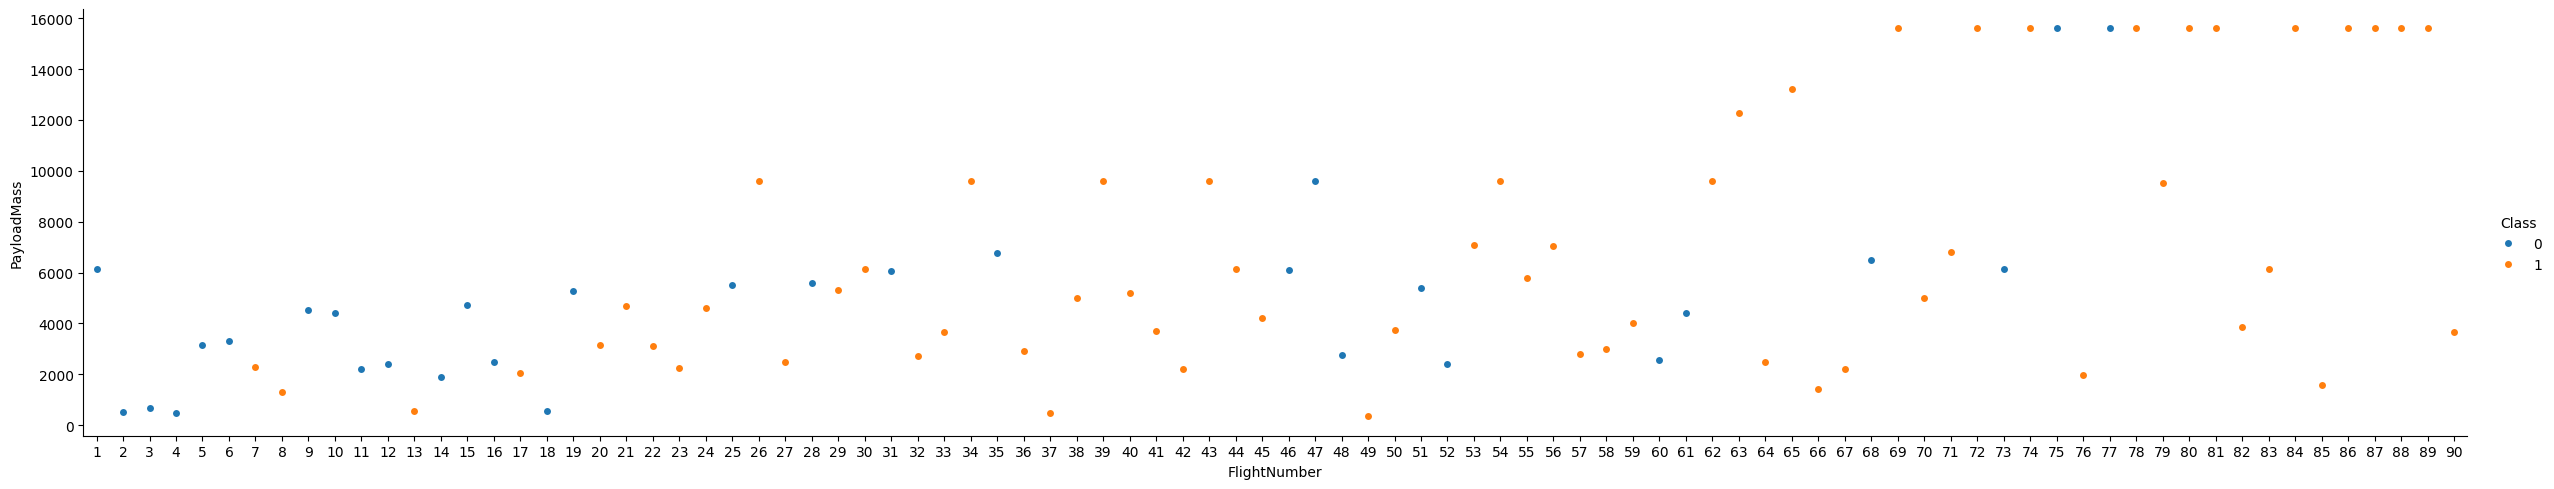

In [54]:
sns.catplot(y="PayloadMass", x="FlightNumber", hue="Class", data=df2, aspect=5)

### TASK 1: Visualize the relationship between Flight Number and Launch Site


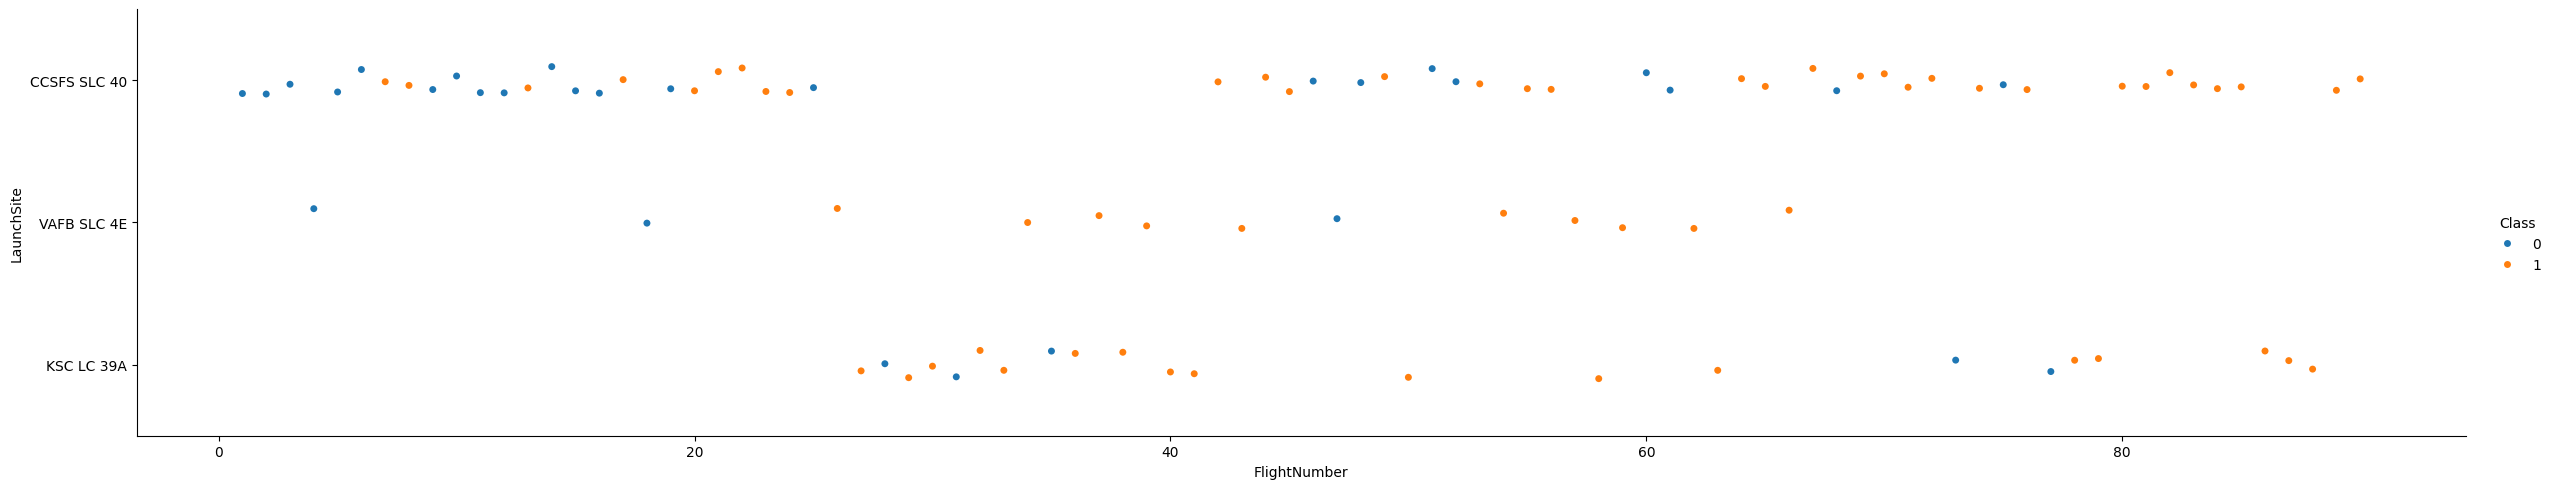

In [55]:
sns.catplot(y="LaunchSite", x="FlightNumber", hue="Class", data=df2, aspect=5)

Here, we see that for launch site `CCSFS SLC 40`, the number of successful launches are higher as compared to unsuccessful launches when the flight number is higher.

We see that the `VAFB SLC 4E` launch site is used lesser times as compared to the other two launch sites.

We see that `KSC LC 39A` site came to use after more than 20 launch attempts from other two sites.

We see that in the first two launch sites, the number of unsuccessful launches is more when the launch attempts are less.

### TASK 2: Visualize the relationship between Payload and Launch Site



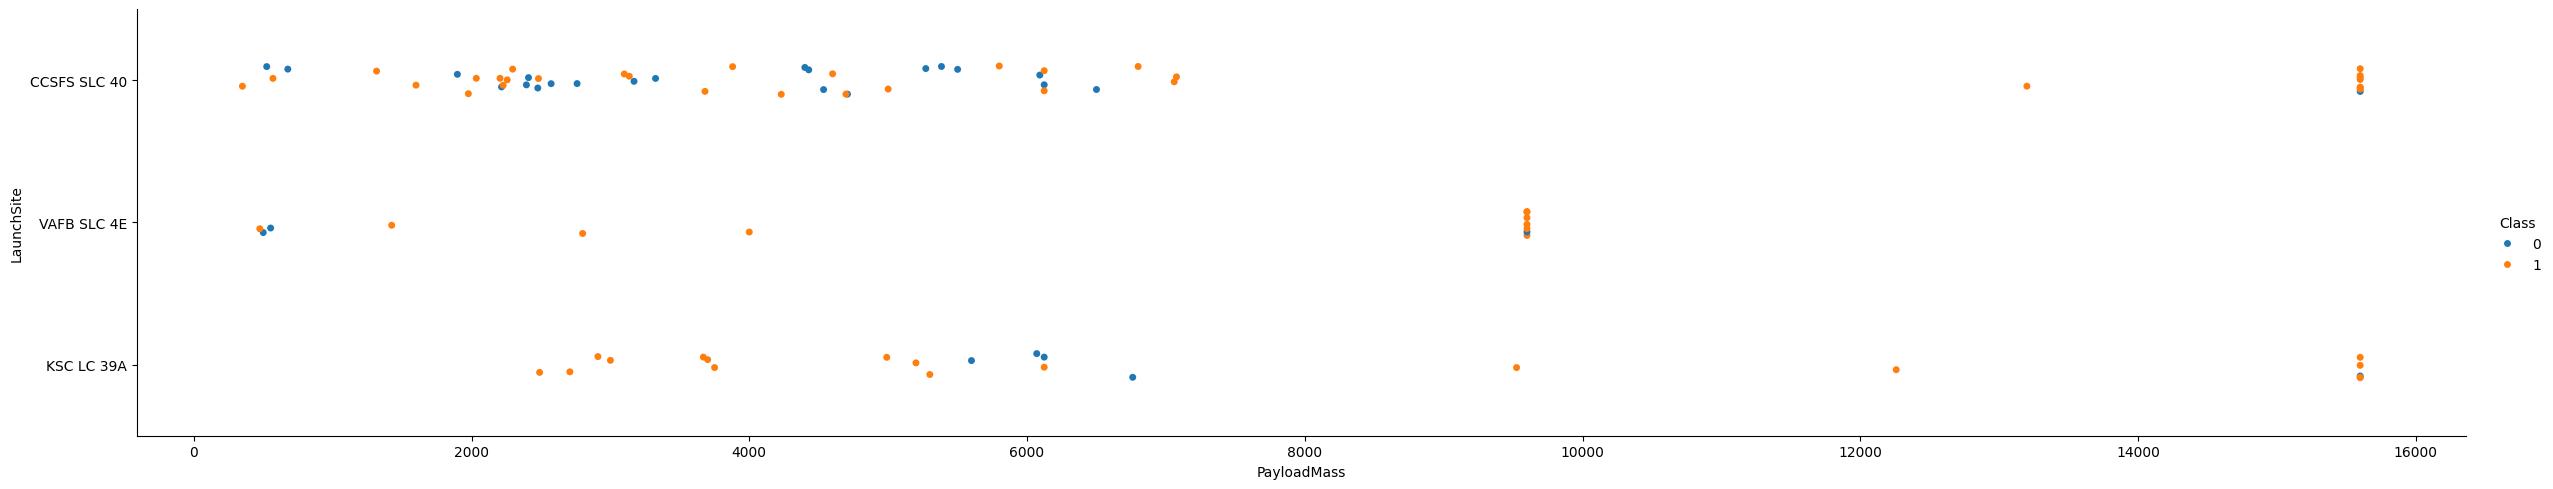

In [56]:
sns.catplot(y="LaunchSite", x="PayloadMass", hue="Class", data=df2, aspect=5)

Here, we can see that payload with mass greater than 10,000 is not launched from `VAFB SLC 4E` site.
We can also see that number of unsuccessful launches are more when the payload mass is higher in all the launch sites.   

###Task 3: Visualize the relationship between success rate of each orbit type

<Axes: xlabel='Orbit', ylabel='Class'>

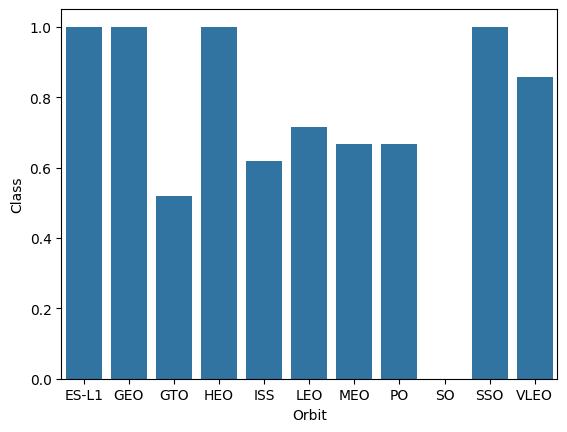

In [57]:
df_orbit = df2.groupby(df2['Orbit'], as_index=False).agg({"Class": "mean"})
df_orbit
sns.barplot(y="Class", x="Orbit", data=df_orbit)

### TASK 4: Visualize the relationship between FlightNumber and Orbit type

For each orbit, we want to see if there is any relationship between FlightNumber and Orbit type.


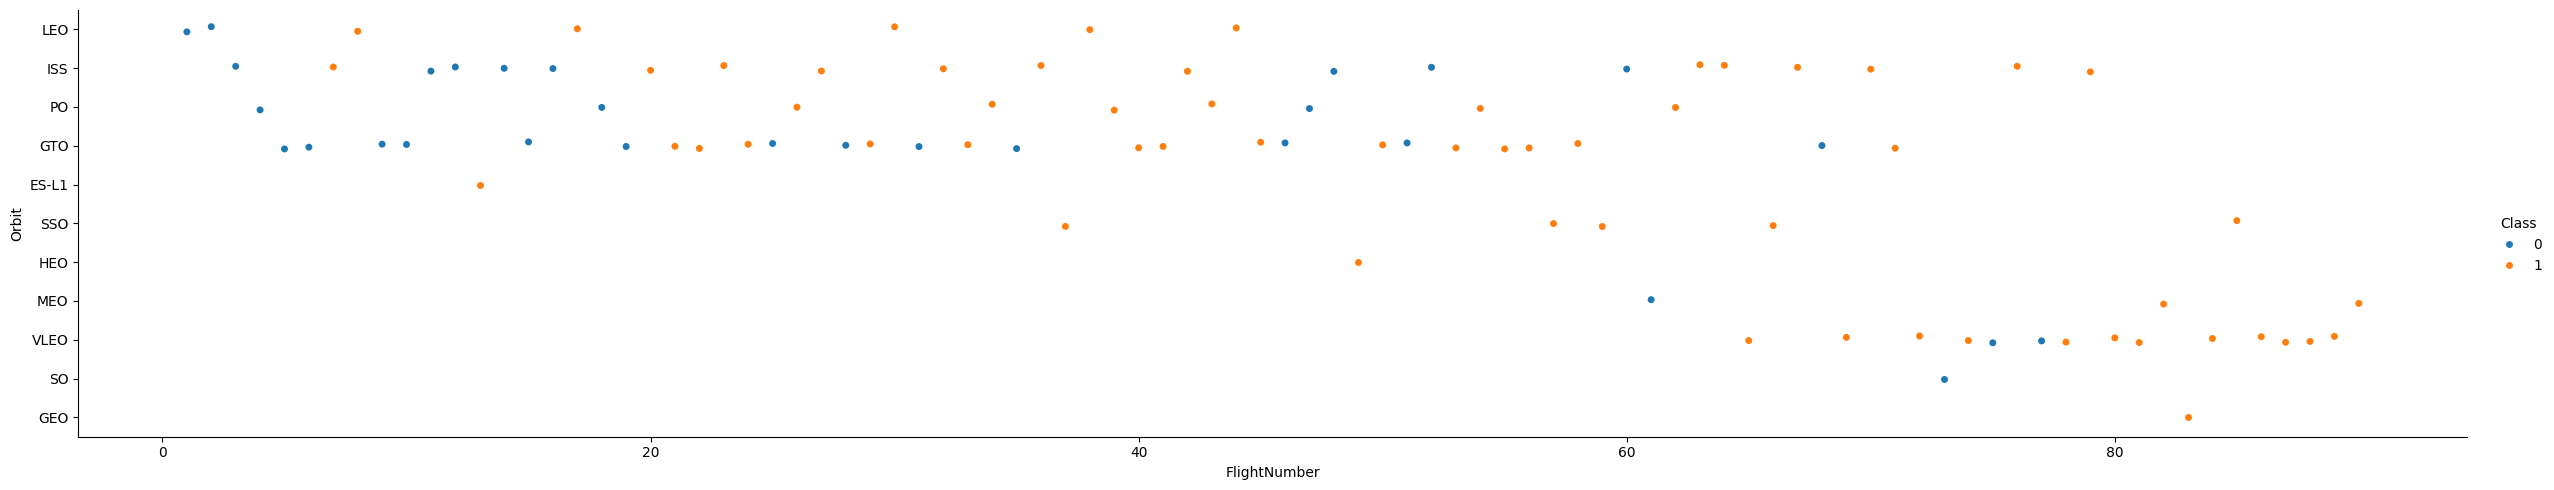

In [58]:
sns.catplot(y="Orbit", x="FlightNumber", data=df2, hue="Class", aspect=5)



You should see that in the LEO orbit the Success appears related to the number of flights; on the other hand, there seems to be no relationship between flight number when in GTO orbit.


### TASK 5: Visualize the relationship between Payload and Orbit type

Similarly, we can plot the Payload vs. Orbit scatter point charts to reveal the relationship between Payload and Orbit type


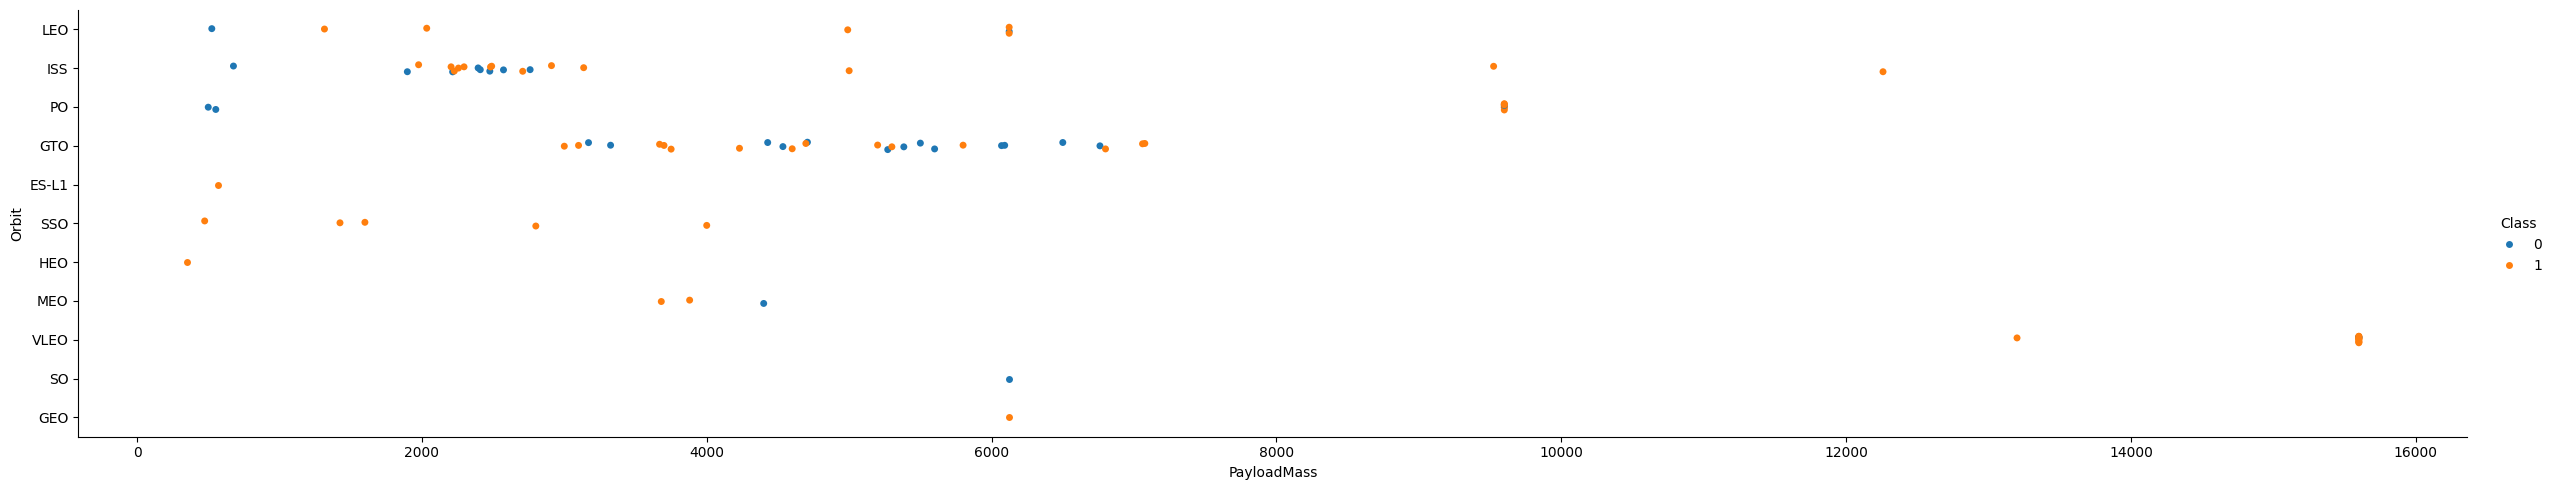

In [59]:
sns.catplot(y="Orbit", x="PayloadMass", hue="Class", data=df2, aspect=5)

 With heavy payloads the successful landing or positive landing rate are more for Polar,LEO and ISS.

However for GTO we cannot distinguish this well as both positive landing rate and negative landing(unsuccessful mission) are both there here.


### TASK 6: Visualize the launch success yearly trend

You can plot a line chart with x axis to be Year and y axis to be average success rate, to get the average launch success trend.

The function will help you get the year from the date:


In [60]:
# A function to Extract years from the date
year=[]
def Extract_year(date):
    for i in df["Date"]:
        year.append(i.split("-")[0])
    return year


<Axes: xlabel='Year', ylabel='Class'>

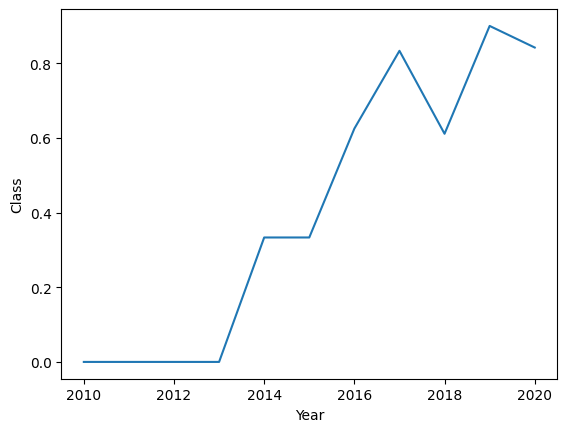

In [61]:
# add year column
df2["Year"] = pd.DatetimeIndex(df["Date"]).year.astype(int)

df_year = df2.groupby(df2['Year'], as_index=False).agg({"Class": "mean"})
#df_orbit
sns.lineplot(y="Class", x="Year", data=df_year)


We can observe that the success rate since 2013 kept increasing till 2017 (stable in 2014) and after 2015 it started increasing.


### Features Engineering

By now, you should obtain some preliminary insights about how each important variable would affect the success rate, we will select the features that will be used in success prediction in the future module.



In [62]:
features = df[['FlightNumber', 'PayloadMass', 'Orbit', 'LaunchSite', 'Flights', 'GridFins', 'Reused', 'Legs', 'LandingPad', 'Block', 'ReusedCount', 'Serial','Class']]
features.head()


,FlightNumber,PayloadMass,Orbit,LaunchSite,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Class
0,1,6123.547647,LEO,CCSFS SLC 40,1,False,False,False,NaN,1.0,0,B0003,0
1,2,525.000000,LEO,CCSFS SLC 40,1,False,False,False,NaN,1.0,0,B0005,0
2,3,677.000000,ISS,CCSFS SLC 40,1,False,False,False,NaN,1.0,0,B0007,0
3,4,500.000000,PO,VAFB SLC 4E,1,False,False,False,NaN,1.0,0,B1003,0
4,5,3170.000000,GTO,CCSFS SLC 40,1,False,False,False,NaN,1.0,0,B1004,0


### TASK 7: Create dummy variables to categorical columns

Use the function `get_dummies` and `features` dataframe to apply OneHotEncoder to the column Orbits, LaunchSite, LandingPad, and Serial. Assign the value to the variable features_one_hot, display the results using the method head. Your result dataframe must include all features including the encoded ones

In [63]:
features_one_hot = pd.get_dummies(features[['Orbit','LaunchSite','LandingPad','Serial']])

features_one_hot = pd.concat([features[['FlightNumber','PayloadMass','Flights','GridFins','Reused','Legs','Block','ReusedCount','Class']],features_one_hot], axis=1)

In [64]:
features_one_hot.head(10)
features_one_hot = features_one_hot.astype(float)
features_one_hot.dtypes

FlightNumber    float64
PayloadMass     float64
Flights         float64
GridFins        float64
Reused          float64
                 ...   
Serial_B1056    float64
Serial_B1058    float64
Serial_B1059    float64
Serial_B1060    float64
Serial_B1062    float64
Length: 81, dtype: object

In [65]:
features_one_hot.head(10)


,FlightNumber,PayloadMass,Flights,GridFins,Reused,Legs,Block,ReusedCount,Class,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SO,Orbit_SSO,Orbit_VLEO,LaunchSite_CCSFS SLC 40,LaunchSite_KSC LC 39A,LaunchSite_VAFB SLC 4E,LandingPad_5e9e3032383ecb267a34e7c7,LandingPad_5e9e3032383ecb554034e7c9,LandingPad_5e9e3032383ecb6bb234e7ca,LandingPad_5e9e3032383ecb761634e7cb,LandingPad_5e9e3033383ecbb9e534e7cc,Serial_B0003,Serial_B0005,Serial_B0007,Serial_B1003,Serial_B1004,Serial_B1005,Serial_B1006,Serial_B1007,Serial_B1008,Serial_B1010,Serial_B1011,Serial_B1012,Serial_B1013,Serial_B1015,Serial_B1016,Serial_B1017,Serial_B1018,Serial_B1019,Serial_B1020,Serial_B1021,Serial_B1022,Serial_B1023,Serial_B1025,Serial_B1026,Serial_B1028,Serial_B1029,Serial_B1030,Serial_B1031,Serial_B1032,Serial_B1034,Serial_B1035,Serial_B1036,Serial_B1037,Serial_B1038,Serial_B1039,Serial_B1040,Serial_B1041,Serial_B1042,Serial_B1043,Serial_B1044,Serial_B1045,Serial_B1046,Serial_B1047,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062
0,1.0,6123.547647,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,525.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,677.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,500.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.0,3170.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,6.0,3325.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,7.0,2296.000000,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,8.0,1316.000000,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,9.0,4535.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [66]:
df_feat = features_one_hot

In [67]:
df_feat.to_csv("dataset_part_3.csv", index=False)



The launch success rate may depend on many factors such as payload mass, orbit type, and so on. It may also depend on the location and proximities of a launch site, i.e., the initial position of rocket trajectories. Finding an optimal location for building a launch site certainly involves many factors and hopefully we could discover some of the factors by analyzing the existing launch site locations.

In the previous exploratory data analysis labs, you have visualized the SpaceX launch dataset using matplotlib and seaborn and discovered some preliminary correlations between the launch site and success rates. In this lab, we will be performing more interactive visual analytics using Folium.


In [68]:
!pip3 install folium
!pip3 install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=25c6b140adc8830142507314cd75c33a32a41386b1cf02789690e42a6152b159
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [69]:
import folium
import wget
import pandas as pd

In [70]:
# Import folium MarkerCluster plugin
from folium.plugins import MarkerCluster
# Import folium MousePosition plugin
from folium.plugins import MousePosition
# Import folium DivIcon plugin
from folium.features import DivIcon

### Task 1: Mark all launch sites on a map

First, let's try to add each site's location on a map using site's latitude and longitude coordinates

The following dataset with the name spacex_launch_geo.csv is an augmented dataset with latitude and longitude added for each site.


In [71]:
# Download and read the `spacex_launch_geo.csv`
spacex_csv_file = wget.download('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/spacex_launch_geo.csv')
spacex_df = pd.read_csv(spacex_csv_file)

In [72]:
spacex_df = spacex_df[['Launch Site','Lat','Long','class']]

In [73]:
launch_sites = spacex_df.groupby(['Launch Site'], as_index = False).first()

In [74]:
launch_sites.head()

,Launch Site,Lat,Long,class
0,CCAFS LC-40,28.562302,-80.577356,0
1,CCAFS SLC-40,28.563197,-80.576820,1
2,KSC LC-39A,28.573255,-80.646895,1
3,VAFB SLC-4E,34.632834,-120.610745,0


In [75]:
launch_sites_df = launch_sites[['Launch Site', 'Lat', 'Long']]

In [76]:
len(launch_sites_df)

4



Above coordinates are just plain numbers that can not give you any intuitive insights about where are those launch sites. Let's visualize those locations by pinning them on a map.

We first need to create a folium Map object, with an initial center location to be NASA Johnson Space Center at Houston, Texas.


In [77]:
nasa_coordinate = [29.559684888503615, -95.0830971930759]
site_map = folium.Map(location=nasa_coordinate, zoom_start=10)

We could use folium.Circle to add a highlighted circle area with a text label on a specific coordinate. For example,

In [78]:
circle = folium.Circle(nasa_coordinate, radius=1000, color='#d35400', fill=True).add_child(folium.Popup('NASA Johnson Space Center'))
marker = folium.map.Marker(
    nasa_coordinate,
    # Create an icon as a text label
    icon=DivIcon(
        icon_size=(20,20),
        icon_anchor=(0,0),
        html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % 'NASA JSC',
        )
    )


site_map.add_child(circle)
site_map.add_child(marker)



Now, let's add a circle for each launch site in data frame launch_sites

TODO: Create and add folium.Circle and folium.Marker for each launch site on the site map

In [79]:
# Initialize map
center_coords = [launch_sites_df[['Lat']].max() * 0.5 + launch_sites_df[['Lat']].min() * 0.5, launch_sites_df[['Long']].max() * 0.5 + launch_sites_df[['Long']].min() * 0.5]
site_map = folium.Map(location=center_coords, zoom_start=4)

/usr/local/lib/python3.10/dist-packages/folium/utilities.py:69: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(coord)
/usr/local/lib/python3.10/dist-packages/folium/utilities.py:77: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  if math.isnan(float(coord)):
/usr/local/lib/python3.10/dist-packages/folium/utilities.py:79: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return [float(x) for x in coords]


In [80]:
# For each launch site, add a Circle object based on its coordinate (Lat, Long) values. In addition, add Launch site name as a popup label

for _,launch_site in launch_sites_df.iterrows():
  coord = [launch_site['Lat'], launch_site['Long']]
  ls_name = [launch_site['Launch Site']]

  circle = folium.Circle(coord, radius=1000, color='#0054d3', fill=True).add_child(folium.Popup(ls_name))
  marker = folium.map.Marker(
        coord,
        # Create an icon as a text label
        icon=DivIcon(
            icon_size=(20,20),
            icon_anchor=(0,0),
            html='<div style="font-size: 12; color:#0054d3;"><b>%s</b></div>' % ls_name,
            )
        )

  site_map.add_child(circle)
  site_map.add_child(marker)

In [81]:
site_map



Now, you can explore the map by zoom-in/out the marked areas

    Are all launch sites in proximity to the Equator line? No
    Are all launch sites in very close proximity to the coast? Yes


###Task 2: Mark the success/failed launches for each site on the map

Next, let's try to enhance the map by adding the launch outcomes for each site, and see which sites have high success rates. Recall that data frame spacex_df has detailed launch records, and the class column indicates if this launch was successful or not


In [82]:
spacex_df.head()

,Launch Site,Lat,Long,class
0,CCAFS LC-40,28.562302,-80.577356,0
1,CCAFS LC-40,28.562302,-80.577356,0
2,CCAFS LC-40,28.562302,-80.577356,0
3,CCAFS LC-40,28.562302,-80.577356,0
4,CCAFS LC-40,28.562302,-80.577356,0




Next, let's create markers for all launch records. If a launch was successful (class=1), then we use a green marker and if a launch was failed, we use a red marker (class=0)

Note that a launch only happens in one of the four launch sites, which means many launch records will have the exact same coordinate. Marker clusters can be a good way to simplify a map containing many markers having the same coordinate.


In [83]:
marker_cluster = MarkerCluster().add_to(site_map)


In [84]:
# TODO: Create a new column in launch_sites dataframe called marker_color to store the marker colors based on the class value
# Function to assign color to launch outcome
def assign_marker_color(launch_outcome):
    if launch_outcome == 1:
        return 'green'
    else:
        return 'red'

spacex_df['marker_color'] = spacex_df['class'].apply(assign_marker_color)
spacex_df.tail(10)

,Launch Site,Lat,Long,class,marker_color
46,KSC LC-39A,28.573255,-80.646895,1,green
47,KSC LC-39A,28.573255,-80.646895,1,green
48,KSC LC-39A,28.573255,-80.646895,1,green
49,CCAFS SLC-40,28.563197,-80.576820,1,green
50,CCAFS SLC-40,28.563197,-80.576820,1,green
51,CCAFS SLC-40,28.563197,-80.576820,0,red
52,CCAFS SLC-40,28.563197,-80.576820,0,red
53,CCAFS SLC-40,28.563197,-80.576820,0,red
54,CCAFS SLC-40,28.563197,-80.576820,1,green
55,CCAFS SLC-40,28.563197,-80.576820,0,red


In [85]:
for index, record in spacex_df.iterrows():
  folium.Marker( location=[record['Lat'], record['Long']],
        icon=folium.Icon(color=record['marker_color'], icon_color=record['marker_color'],
        popup=record['class'])
    ).add_to(marker_cluster)

site_map

###TASK 3: Calculate the distances between a launch site to its proximities




Next, we need to explore and analyze the proximities of launch sites.

Let's first add a MousePosition on the map to get coordinate for a mouse over a point on the map. As such, while you are exploring the map, you can easily find the coordinates of any points of interests (such as railway)


In [86]:
# Add Mouse Position to get the coordinate (Lat, Long) for a mouse over on the map
formatter = "function(num) {return L.Util.formatNum(num, 5);};"
mouse_position = MousePosition(
    position='topright',
    separator=' Long: ',
    empty_string='NaN',
    lng_first=False,
    num_digits=20,
    prefix='Lat:',
    lat_formatter=formatter,
    lng_formatter=formatter,
)

site_map.add_child(mouse_position)
site_map



Now zoom in to a launch site and explore its proximity to see if you can easily find any railway, highway, coastline, etc. Move your mouse to these points and mark down their coordinates (shown on the top-left) in order to the distance to the launch site.

You can calculate the distance between two points on the map based on their Lat and Long values using the following method:


In [87]:
from math import sin, cos, sqrt, atan2, radians

def calculate_distance(lat1, lon1, lat2, lon2):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

Mark down a point on the closest coastline using MousePosition and calculate the distance between the coastline point and the launch site.

In [88]:
# find coordinate of the closet coastline
# distance_coastline = calculate_distance(launch_site_lat, launch_site_lon, coastline_lat, coastline_lon)

launch_site_lat, launch_site_lon = 28.563197, -80.576820
coastline_lat, coastline_lon = 28.56319, -80.56785

distance_coastline = calculate_distance(launch_site_lat, launch_site_lon, coastline_lat, coastline_lon)
distance_coastline

0.8762983388668405

In [89]:
# Create and add a folium.Marker on your selected closest coastline point on the map
# Display the distance between coastline point and launch site using the icon property
distance_marker = folium.Marker(
   location=[coastline_lat, coastline_lon],
   icon=DivIcon(
       icon_size=(20,20),
       icon_anchor=(0,0),
       html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % "{:10.2f} KM".format(distance_coastline),
       )
   )

In [90]:
# Create a `folium.PolyLine` object using the coastline coordinates and launch site coordinate
lines=folium.PolyLine(locations=[[launch_site_lat, launch_site_lon], [coastline_lat, coastline_lon]], weight=1)
site_map.add_child(lines)



TODO: Similarly, you can draw a line betwee a launch site to its closest city, railway, highway, etc. You need to use MousePosition to find the their coordinates on the map first





In [91]:
city_lat, city_lon = 28.53, -81.38  # coords for Orlando

line2=folium.PolyLine(locations=[[launch_site_lat, launch_site_lon], [city_lat, city_lon]], weight=3)
site_map.add_child(line2)

In [92]:
# Preprocessing allows us to standarsize our data
from sklearn import preprocessing

# Allows us to split our data into training and testing data
from sklearn.model_selection import train_test_split

# Allows us to test parameters of classification algorithms and find the best one
from sklearn.model_selection import GridSearchCV

# Logistic Regression classification algorithm
from sklearn.linear_model import LogisticRegression

# Support Vector Machine classification algorithm
from sklearn.svm import SVC

# Decision Tree classification algorithm
from sklearn.tree import DecisionTreeClassifier

# K Nearest Neighbors classification algorithm
from sklearn.neighbors import KNeighborsClassifier

This function is to plot the confusion matrix.

In [100]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix');
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed'])
    plt.show()

In [101]:
#dataset_part_2.csv is my df
#dataset_part_3.csv is features_one_hot/df_feat
data = df
X = df_feat

In [102]:
data.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6123.547647,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


In [114]:
X = df_feat.reset_index().drop(['index'], axis=1)
X.head(100)

,FlightNumber,PayloadMass,Flights,GridFins,Reused,Legs,Block,ReusedCount,Class,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SO,Orbit_SSO,Orbit_VLEO,LaunchSite_CCSFS SLC 40,LaunchSite_KSC LC 39A,LaunchSite_VAFB SLC 4E,LandingPad_5e9e3032383ecb267a34e7c7,LandingPad_5e9e3032383ecb554034e7c9,LandingPad_5e9e3032383ecb6bb234e7ca,LandingPad_5e9e3032383ecb761634e7cb,LandingPad_5e9e3033383ecbb9e534e7cc,Serial_B0003,Serial_B0005,Serial_B0007,Serial_B1003,Serial_B1004,Serial_B1005,Serial_B1006,Serial_B1007,Serial_B1008,Serial_B1010,Serial_B1011,Serial_B1012,Serial_B1013,Serial_B1015,Serial_B1016,Serial_B1017,Serial_B1018,Serial_B1019,Serial_B1020,Serial_B1021,Serial_B1022,Serial_B1023,Serial_B1025,Serial_B1026,Serial_B1028,Serial_B1029,Serial_B1030,Serial_B1031,Serial_B1032,Serial_B1034,Serial_B1035,Serial_B1036,Serial_B1037,Serial_B1038,Serial_B1039,Serial_B1040,Serial_B1041,Serial_B1042,Serial_B1043,Serial_B1044,Serial_B1045,Serial_B1046,Serial_B1047,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062
0,1.0,6123.547647,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,525.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,677.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,500.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.0,3170.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,86.0,15600.000000,2.0,1.0,1.0,1.0,5.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
86,87.0,15600.000000,3.0,1.0,1.0,1.0,5.0,13.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
87,88.0,15600.000000,6.0,1.0,1.0,1.0,5.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

###TASK 1

*Create* a NumPy array from the column Class in data, by applying the method to_numpy() then assign it to the variable Y,make sure the output is a Pandas series (only one bracket df['name of column']).

In [116]:
y = X['Class']

In [117]:
X.drop(['Class'], axis=1, inplace=True)

###TASK 2



In [119]:
X = preprocessing.StandardScaler().fit_transform(X)
X



array([[-1.71291154,  0.        , -0.65391284, ..., -0.21566555,
        -0.18569534, -0.10599979],
       [-1.67441914, -1.18972425, -0.65391284, ..., -0.21566555,
        -0.18569534, -0.10599979],
       [-1.63592675, -1.15742336, -0.65391284, ..., -0.21566555,
        -0.18569534, -0.10599979],
       ...,
       [ 1.63592675,  2.01380177,  3.49060516, ..., -0.21566555,
        -0.18569534, -0.10599979],
       [ 1.67441914,  2.01380177,  1.00389436, ..., -0.21566555,
         5.38516481, -0.10599979],
       [ 1.71291154, -0.51905572, -0.65391284, ..., -0.21566555,
        -0.18569534,  9.43398113]])

We split the data into training and testing data using the function train_test_split. The training data is divided into validation data, a second set used for training data; then the models are trained and hyperparameters are selected using the function GridSearchCV.

###TASK 3

Use the function train_test_split to split the data X and Y into training and test data. Set the parameter test_size to 0.2 and random_state to 2. The training data and test data should be assigned to the following labels.

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2)
y_test.shape

(18,)

###TASK 4

Create a logistic regression object then create a GridSearchCV object logreg_cv with cv = 10. Fit the object to find the best parameters from the dictionary parameters.


In [125]:
parameters ={"C":[0.01,0.1,1],'penalty':['l2'], 'solver':['lbfgs']}# l1 lasso l2 ridge
lr=LogisticRegression()


In [126]:
logreg_cv = GridSearchCV(lr, parameters, cv=10) #cv Determines the cross-validation splitting strategy

We output the <code>GridSearchCV</code> object for logistic regression. We display the best parameters using the data attribute <code>best_params\_</code> and the accuracy on the validation data using the data attribute <code>best_score\_</code>.


In [128]:
logreg_cv.fit(X, y)
logreg_cv.best_estimator_

LogisticRegression(C=0.1)

In [130]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.8222222222222222


###TASK 5

Calculate the accuracy on the test data using the method score:


In [131]:
print('score on train data: ', logreg_cv.score(X_train, y_train))  # R² score on train data
print('score on test data : ', logreg_cv.score(X_test, y_test))  # R² score on test data

score on train data:  0.9722222222222222
score on test data :  0.9444444444444444


The confusion matrix looks like follows:


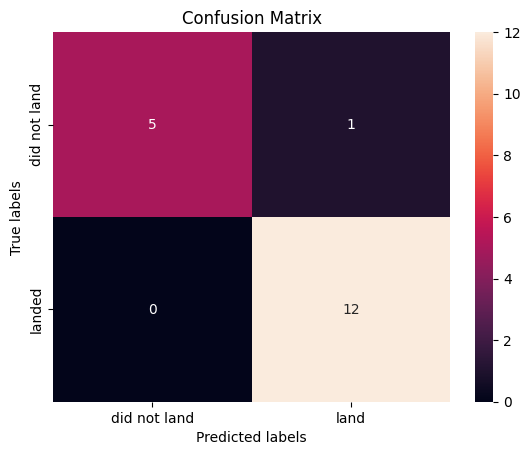

In [133]:
yhat=logreg_cv.predict(X_test)
plot_confusion_matrix(y_test,yhat)

Examining the confusion matrix, we see that logistic regression can distinguish between the different classes. We see that the major problem is false positives.

### TASK 6

Create a support vector machine object then create a GridSearchCV object svm_cv with cv = 10. Fit the object to find the best parameters from the dictionary parameters.


In [135]:
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}  # from 10^-3 to 10^3 in 6 steps with equal quotients
svm = SVC()

In [136]:
svm_cv = GridSearchCV(svm, parameters, cv=10)

In [138]:
svm_cv.fit(X, y)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'gamma': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'kernel': ('linear', 'rbf', 'poly', 'rbf', 'sigmoid')})

In [140]:
svm_cv.best_estimator_

SVC(gamma=0.03162277660168379, kernel='sigmoid')

In [141]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.8222222222222222


###TASK 7

Calculate the accuracy on the test data using the method score:


In [142]:
print('score on train data: ', svm_cv.score(X_train, y_train))  # R² score on train data
print('score on test data : ', svm_cv.score(X_test, y_test))  # R² score on test data

score on train data:  0.9027777777777778
score on test data :  0.9444444444444444


We can plot the confusion matrix

In [144]:
yhat = svm_cv.predict(X_test)

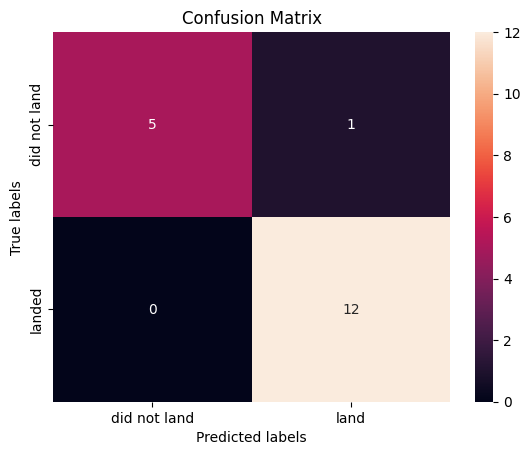

In [145]:
plot_confusion_matrix(y_test,yhat)

### TASK 8

Create a decision tree classifier object then create a GridSearchCV object tree_cv with cv = 10. Fit the object to find the best parameters from the dictionary parameters.


In [146]:
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()

In [147]:
tree_cv = GridSearchCV(tree, parameters, cv = 10)

In [149]:
tree_cv.fit(X, y)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_feat

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']})

In [150]:
tree_cv.best_estimator_

DecisionTreeClassifier(max_depth=18, max_features='sqrt', min_samples_split=10,
                       splitter='random')

In [151]:
print("tuned hpyerparameters :(best parameters) ",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'criterion': 'gini', 'max_depth': 18, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'splitter': 'random'}
accuracy : 0.888888888888889


###TASK 9

Calculate the accuracy of tree_cv on the test data using the method score:


In [152]:
print('score on train data: ', tree_cv.score(X_train, y_train))  # R² score on train data
print('score on test data : ', tree_cv.score(X_test, y_test))  # R² score on test data

score on train data:  0.8472222222222222
score on test data :  0.8888888888888888



###TASK 10

Create a k nearest neighbors object then create a GridSearchCV object knn_cv with cv = 10. Fit the object to find the best parameters from the dictionary parameters.


In [153]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()

knn_cv = GridSearchCV(KNN, parameters, cv=10)
knn_cv.fit(X, y)
knn_cv.best_estimator_

print("tuned hpyerparameters :(best parameters) ", knn_cv.best_params_)
print("accuracy :", knn_cv.best_score_)



tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 8, 'p': 1}
accuracy : 0.8



###TASK 11
Calculate the accuracy of knn_cv on the test data using the method score:


In [154]:
print('score on train data: ', knn_cv.score(X_train, y_train))  # R² score on train data
print('score on test data : ', knn_cv.score(X_test, y_test))  # R² score on test data

score on train data:  0.8333333333333334
score on test data :  0.8888888888888888


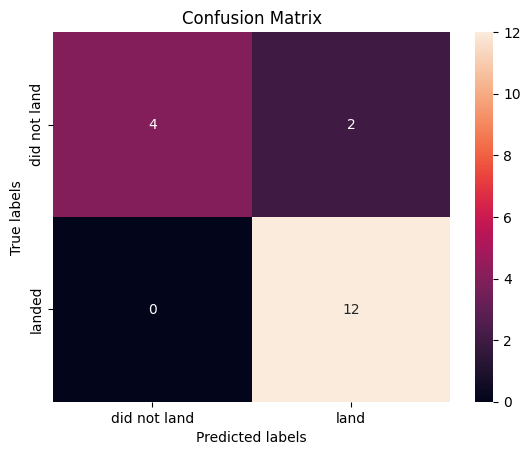

In [155]:
yhat = knn_cv.predict(X_test)
plot_confusion_matrix(y_test,yhat)



### TASK 12

Find the method performs best:
Scores on test data for each method

    * Logistic Regression: 0.944
    * SVM: 0.944
    * Decision Tree: 0.888
    * KNN: 0.888

Conclusion: Logistic Regression and SVM deliver the best performance on test data.


#Thank You!